In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import psutil
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Data augmentation for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Data augmentation for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Handle class imbalance with WeightedRandomSampler
class_counts = np.bincount([label for _, label in train_dataset])
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Define Mixup function
def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Define Mixup loss function
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
# Load pre-trained ResNet-18, unfreeze layers, and modify classifier
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 10)
)
model = model.to(device)

# Define loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer and learning rate scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

In [ ]:
import os

# Training settings
num_epochs = 45
train_losses, val_losses = [], []
metrics_log = []
best_val_loss = float('inf')
early_stop_counter = 0
patience = 5

# File to save metrics
metrics_file = '/kaggle/working/training_metrics_log.txt'

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Apply Mixup
        images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.2)

        optimizer.zero_grad()
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
     # Log additional metrics
    training_time = time.time() - start_time
    memory_usage = psutil.Process().memory_info().rss / (1024 ** 2)  # Memory usage in MB

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, f'/kaggle/working/resnet18_model_latest.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

    # Log metrics
    epoch_log = f"Epoch {epoch+1}/{num_epochs}\n" \
                f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}\n" \
                f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n" \
                f"Training Time: {training_time:.2f} seconds, Memory Usage: {memory_usage:.2f} MB\n"
    print(epoch_log)
    metrics_log.append(epoch_log)

    # Update scheduler
    scheduler.step()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    plt.show()

# Plot training and validation loss curves
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save metrics to a file
with open(metrics_file, 'w') as f:
    f.writelines(metrics_log)

print(f"Metrics logged and saved to {metrics_file}")

/tmp/ipykernel_30/218326292.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


Files already downloaded and verified
Classification Report:
               precision    recall  f1-score   support

       plane       0.75      0.85      0.80      1000
         car       0.84      0.88      0.86      1000
        bird       0.71      0.70      0.70      1000
         cat       0.62      0.60      0.61      1000
        deer       0.76      0.71      0.73      1000
         dog       0.72      0.66      0.69      1000
        frog       0.81      0.84      0.82      1000
       horse       0.82      0.83      0.82      1000
        ship       0.88      0.83      0.85      1000
       truck       0.83      0.83      0.83      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000


Confusion Matrix:
 [[855  21  26  15   8   0   4   7  43  21]
 [ 17 882   4   4   0   2   3   2  21  65]
 [ 69   2 699  41  58  36  58  26   4   7]
 [ 35  10  64 600  52 127  51 

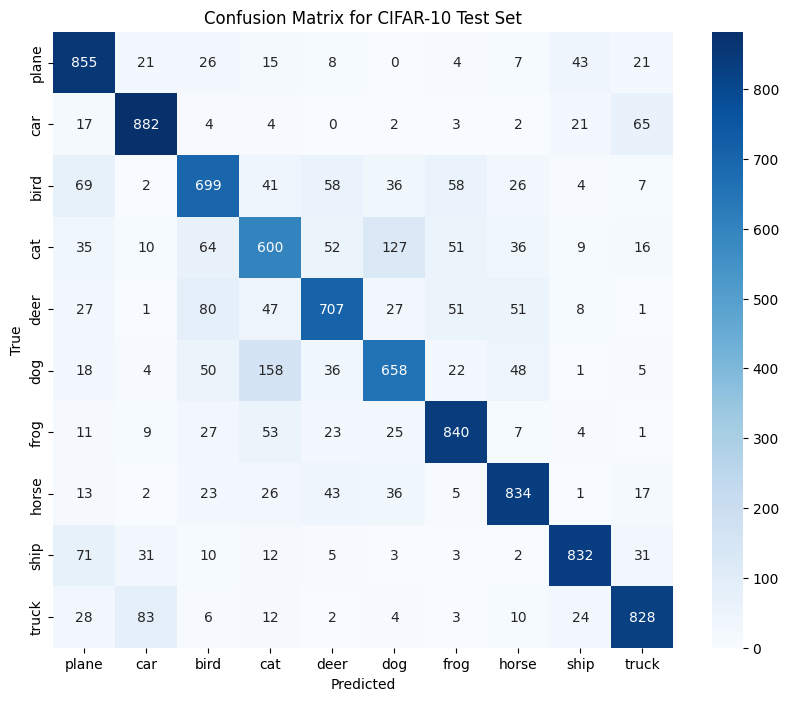

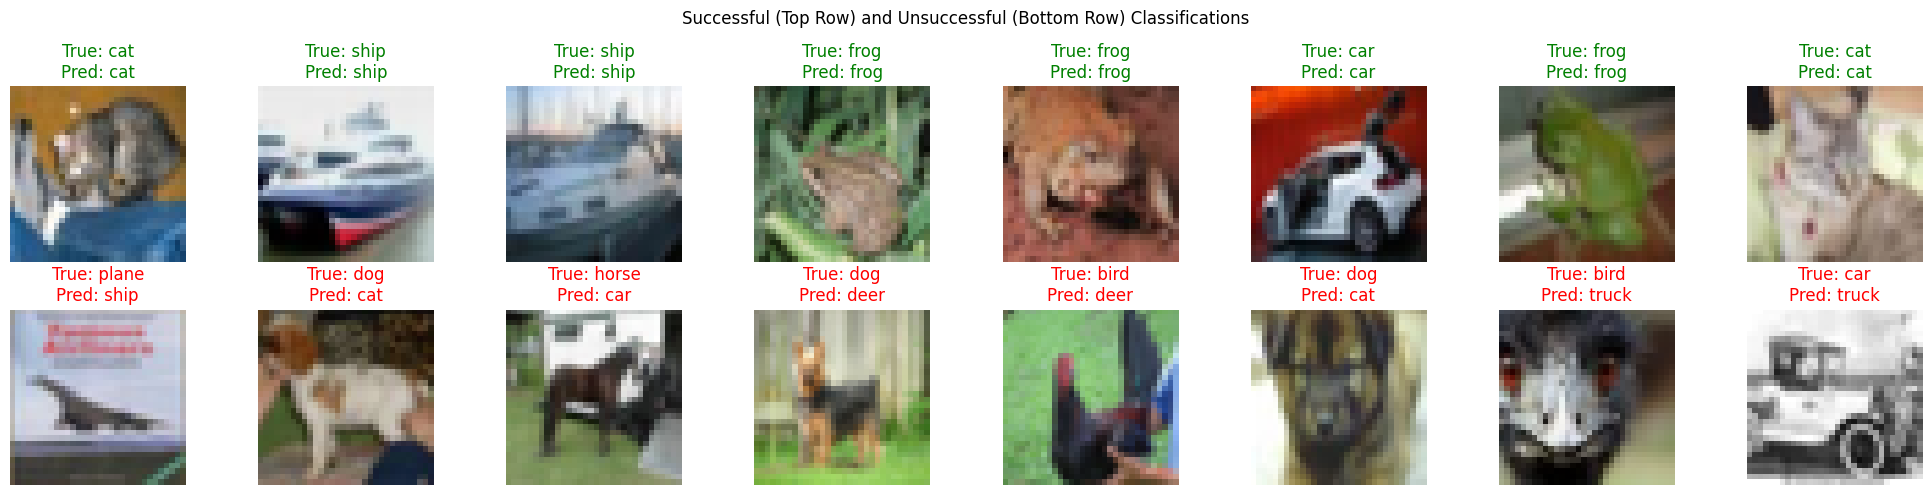

In [4]:
import time  # Import time module for measuring inference time
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    log_loss,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Define CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model checkpoint
model_path = '/kaggle/input/resnet18/pytorch/default/1/resnet18_model_latest.pth'
model = torch.load(model_path, map_location=device)
model.to(device)
model.eval()  # Set model to evaluation mode

# Define the test transformations (for model input)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)  # Use full test set

# Initialize lists to store all predictions and labels
all_labels = []
all_preds = []
all_probs = []

# Measure inference time
start_time = time.time()

# Perform predictions on the full test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_probs = torch.softmax(outputs, dim=1)

        # Store labels, predictions, and probabilities
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(predicted_probs.cpu().numpy())

# Calculate total and average inference time
end_time = time.time()
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(test_dataset)

# Convert lists to arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Calculate evaluation metrics
classification_rep = classification_report(all_labels, all_preds, target_names=classes)
conf_matrix = confusion_matrix(all_labels, all_preds)
logloss = log_loss(all_labels, all_probs)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Handle ROC AUC
try:
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
except ValueError:
    roc_auc = "N/A (requires all classes to have true positive predictions)"

# Print evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)
print(f"\nLog Loss: {logloss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc}")
print(f"\nTotal Inference Time: {total_inference_time:.4f} seconds")
print(f"Average Inference Time per Image: {average_inference_time:.6f} seconds")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for CIFAR-10 Test Set")
plt.show()


# Visualize some successful and unsuccessful classifications
fig, axes = plt.subplots(2, 8, figsize=(20, 5))

# Identify successful and unsuccessful cases
successful_indices = np.where(all_labels == all_preds)[0][:8]  # First 8 successful cases
unsuccessful_indices = np.where(all_labels != all_preds)[0][:8]  # First 8 unsuccessful cases

# Visualize successful classifications
for i, idx in enumerate(successful_indices):
    ax = axes[0, i]
    img = test_dataset.data[idx]
    ax.imshow(img)
    ax.set_title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_preds[idx]]}", color="green")
    ax.axis("off")

# Visualize unsuccessful classifications
for i, idx in enumerate(unsuccessful_indices):
    ax = axes[1, i]
    img = test_dataset.data[idx]
    ax.imshow(img)
    ax.set_title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_preds[idx]]}", color="red")
    ax.axis("off")

fig.suptitle("Successful (Top Row) and Unsuccessful (Bottom Row) Classifications")
plt.tight_layout()
plt.show()

